In [1]:
import pandas as pd
import numpy as np
import math
import os
import datetime

from scipy.spatial.distance import pdist, squareform
from scipy.fftpack import fft
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
import matplotlib.pyplot as plt

In [ ]:
# ## Mount Google drive folder
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [ ]:
# ## Setup working directory and data directory
# DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/Miniprojects/Adil'
# os.chdir(DIR)

In [2]:
## Read data
df = pd.read_csv(r"C:\Users\ibner\Downloads\New folder\data.csv", sep=",", header=0)
df[['date', 'timestamp']] = df['time'].str.split('\s+', expand = True)
df.drop(['time'], axis = 1, inplace = True)
df['date'] =  pd.to_datetime(df['date'], format='%d-%m-%Y')
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%H:%M').dt.time
df.loc[:, (df.columns != 'date') & (df.columns != 'timestamp')] = df.loc[:, df.columns != 'date'].apply(pd.to_numeric, errors = 'coerce')
print(df.dtypes)

Cyclone_Inlet_Gas_Temp             float64
Cyclone_Material_Temp              float64
Cyclone_Outlet_Gas_draft           float64
Cyclone_cone_draft                 float64
Cyclone_Gas_Outlet_Temp            float64
Cyclone_Inlet_Draft                float64
date                        datetime64[ns]
timestamp                           object
dtype: object


Text(0, 0.5, '% Missing Values')

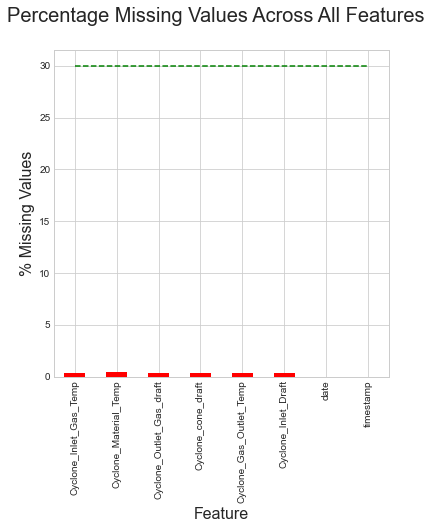

In [3]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--') 
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [4]:
## Linear interpolation for one column
df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df["Cyclone_Material_Temp"] = df["Cyclone_Material_Temp"].interpolate(method='linear')
df["Cyclone_Outlet_Gas_draft"] = df["Cyclone_Outlet_Gas_draft"].interpolate(method='linear')
df["Cyclone_cone_draft"] = df["Cyclone_cone_draft"].interpolate(method='linear')
df["Cyclone_Gas_Outlet_Temp"] = df["Cyclone_Gas_Outlet_Temp"].interpolate(method='linear')
df["Cyclone_Inlet_Draft"] = df["Cyclone_Inlet_Draft"].interpolate(method='linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
date                        0.0
timestamp                   0.0
dtype: float64

In [5]:
## Extract samples for one feature such and apply FFT followed
## by calculation of pairwise distance between magnitude of FFT
## coefficients of each sample
#for first feature.
feature_1 = df.columns[0] # "Cyclone_Inlet_Gas_Temp"
df_1 = df.groupby("date").apply(lambda x: x[feature_1].values if len(x[feature_1].values) == 288 else np.nan)
df_1 = df_1.dropna()
fftmag_1 =  np.abs(np.array([fft(x) for x in df_1.values]))
df_dist_1 = pd.DataFrame(squareform(pdist(np.abs(fftmag_1), 'euclidean')))
df_dist_1.index = df_1.index.copy()
df_dist_1.columns = df_1.index.copy()
df_dist_1.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,5628.044104,4199.429838,4837.248554,3617.631581,5410.006949,3776.449223,4422.006141,3518.221648,3458.164909,...,5017.222070,3198.280346,11063.077810,3178.115138,3232.486244,5206.285927,2629.120831,3542.262579,4073.500605,4461.219685
2017-01-02,5628.044104,0.000000,3584.027498,3389.036289,4396.302146,3461.423939,5950.936084,5573.083726,5035.666610,5528.998922,...,3836.105822,4770.096611,10706.612022,5695.298742,5586.336589,2928.189674,5470.298307,4633.806745,3635.090899,3300.260268
2017-01-03,4199.429838,3584.027498,0.000000,3223.249781,3716.675987,3868.320383,4452.266444,4452.424652,4116.033559,4960.208166,...,3314.325614,2972.280538,11733.478002,3727.800124,3477.855969,3555.553028,3782.035211,3118.332492,2623.143217,2662.765631
2017-01-04,4837.248554,3389.036289,3223.249781,0.000000,4012.018797,3693.038408,4840.753873,4621.347423,4264.470349,5149.846164,...,3961.593487,4249.599973,10408.579665,5053.360726,4846.707527,3604.321137,4885.182410,4382.156917,3650.484289,3635.749643
2017-01-05,3617.631581,4396.302146,3716.675987,4012.018797,0.000000,4331.981287,4982.081002,5158.281236,4082.404381,3547.379601,...,4337.921919,3817.676971,10326.433525,4412.837087,4419.721913,3686.679352,3778.587237,3767.202413,3660.266742,3546.058370


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


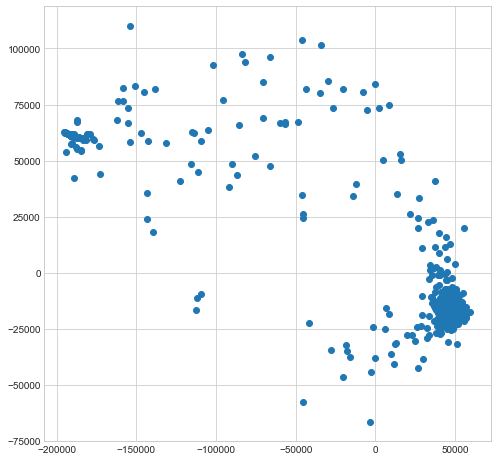

In [7]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_1 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_1 = model_1.fit_transform(df_dist_1)
plt.figure(figsize=(8, 8))
plt.scatter(mds_out_1[:, 0], mds_out_1[:, 1])

In [8]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_1.shape[0])
k = int(np.floor(k))
radius_1 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_1).kneighbors(mds_out_1)[0][:, -1]
f_1 = k / (np.pi * radius_1**2)
f_max_1 = np.amax(f_1)
probability_1 = 1 - (f_1 / f_max_1)

In [9]:
## Anomalous samples
np.where(probability_1 > 0.999)[0]

array([  22,   60,   79,   80,   81,   82,   83,   94,   95,  138,  149,
        150,  158,  159,  164,  200,  211,  251,  254,  255,  256,  261,
        283,  290,  291,  292,  299,  330,  331,  340,  341,  379,  395,
        396,  405,  409,  410,  411,  413,  418,  420,  454,  455,  456,
        457,  482,  483,  484,  486,  492,  499,  514,  515,  519,  520,
        521,  533,  534,  535,  542,  548,  549,  552,  553,  554,  559,
        604,  608,  621,  623,  625,  631,  632,  652,  653,  654,  659,
        662,  671,  672,  694,  695,  696,  697,  703,  704,  706,  710,
        730,  795,  796,  803,  804,  824,  831,  832,  833,  846,  847,
        852,  860,  861,  881,  899,  900,  909,  940,  941,  952,  953,
        956,  984,  985, 1024, 1025, 1026, 1027, 1039, 1050, 1060, 1061,
       1062, 1084, 1085, 1086, 1144, 1145, 1173, 1174, 1175, 1212, 1213,
       1214, 1229, 1299], dtype=int64)

In [10]:
## Function for component-plotting a vector
def plotveccomp(x, xlab, ylab, title, axis = None):
  ax = axis
  component_index = range(0, len(x))
  ax.plot(component_index, x, color = 'black', marker = '') 
  ax.plot(component_index, [np.mean(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='blue') 
  ax.plot(component_index, [np.mean(x) - np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.plot(component_index, [np.mean(x) + np.std(x)]*len(x), linewidth = 1, linestyle = 'dashed', color ='red')
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

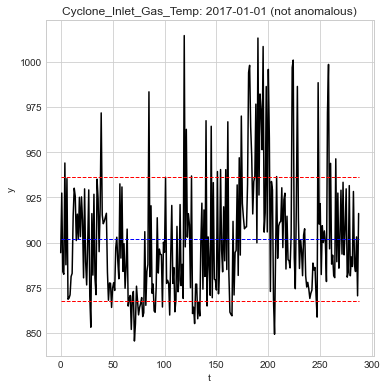

In [19]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_1_na = np.random.choice(np.where(probability_1 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_1.iloc[int(j_1_na)], 't', 'y', feature_1 + ': ' + df_1.index[0].strftime('%Y-%m-%d')+ ' (not anomalous)', ax)

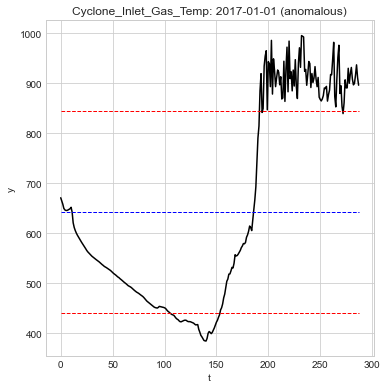

In [20]:
## Randomly pick an anomalous sample and plot
j_1_a = np.random.choice(np.where(probability_1 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_1.iloc[int(j_1_a)], 't', 'y', feature_1 + ': ' + df_1.index[0].strftime('%Y-%m-%d') + ' (anomalous)', ax)

# For the second feature Cyclone_Material_Temp :

In [21]:
feature_2 = df.columns[1] # "Cyclone_Inlet_Gas_Temp"
df_2 = df.groupby("date").apply(lambda x: x[feature_2].values if len(x[feature_2].values) == 288 else np.nan)
df_2 = df_2.dropna()
fftmag_2 =  np.abs(np.array([fft(x) for x in df_2.values]))
df_dist_2 = pd.DataFrame(squareform(pdist(np.abs(fftmag_2), 'euclidean')))
df_dist_2.index = df_2.index.copy()
df_dist_2.columns = df_2.index.copy()
df_dist_2.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,3212.028520,2967.028059,3106.518369,3785.403625,4762.378708,4704.722555,8109.173802,8570.465370,7005.070669,...,28728.213900,11238.431749,18013.972785,12930.255624,12425.064400,9119.006975,12886.494854,9042.679001,8171.518547,8038.414583
2017-01-02,3212.028520,0.000000,4970.790775,5336.194615,5940.239079,3120.378298,6689.439005,10315.489084,10863.659883,8967.575483,...,29835.464252,13486.145730,19685.655993,15127.534212,14677.214583,11021.961818,15167.991014,11280.676827,10474.714349,10285.979479
2017-01-03,2967.028059,4970.790775,0.000000,2632.705807,3770.263930,7027.824429,3036.822637,6004.358816,6614.820710,6087.197292,...,28382.315736,9311.918091,17336.135918,10880.481168,10385.396798,7772.514965,10883.625579,7032.117423,6514.257625,6162.419346
2017-01-04,3106.518369,5336.194615,2632.705807,0.000000,3077.158516,6995.555790,3576.496164,6105.176965,6343.061491,5543.051442,...,27406.984043,9028.461727,16262.897170,10935.995776,10254.496678,7134.624221,10680.542390,6985.274015,6194.869876,5934.538660
2017-01-05,3785.403625,5940.239079,3770.263930,3077.158516,0.000000,7269.141985,5281.367677,7323.577395,6702.435793,5075.916750,...,26787.790504,9803.512269,15598.310367,11739.509914,11219.932760,8252.308500,11162.654694,7868.833051,6744.831466,6643.837219


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


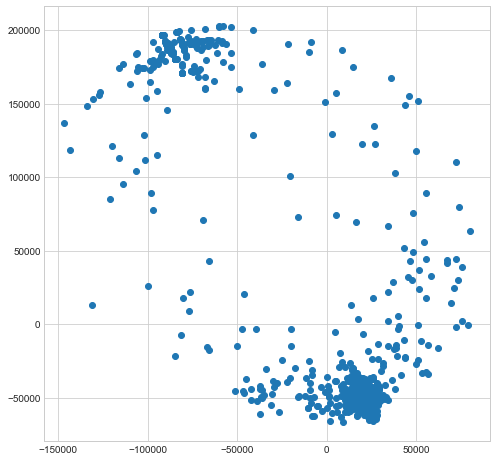

In [22]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_2 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_2 = model_2.fit_transform(df_dist_2)
plt.figure(figsize=(8, 8))
plt.scatter(mds_out_2[:, 0], mds_out_2[:, 1])

In [23]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_2.shape[0])
k = int(np.floor(k))
radius_2 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_2).kneighbors(mds_out_2)[0][:, -1]
f_2 = k / (np.pi * radius_2**2)
f_max_2 = np.amax(f_2)
probability_2 = 1 - (f_2 / f_max_2)

In [24]:
## Anomalous samples
np.where(probability_2 > 0.999)[0]

array([  22,   79,   81,   94,   95,  117,  138,  149,  158,  169,  200,
        203,  211,  213,  251,  253,  254,  255,  261,  270,  271,  272,
        274,  279,  283,  284,  285,  286,  290,  291,  292,  299,  309,
        341,  345,  395,  396,  411,  413,  419,  420,  433,  454,  456,
        466,  482,  484,  489,  499,  515,  519,  534,  535,  536,  538,
        553,  554,  596,  598,  604,  608,  612,  621,  623,  631,  633,
        634,  635,  638,  639,  653,  654,  671,  672,  694,  703,  704,
        706,  795,  803,  804,  831,  832,  836,  846,  847,  852,  860,
        862,  875,  881,  899,  940,  953,  984, 1018, 1019, 1025, 1026,
       1060, 1085, 1144, 1158, 1159, 1212, 1213, 1229, 1271], dtype=int64)

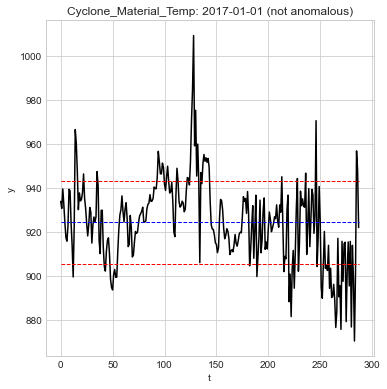

In [25]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_2_na = np.random.choice(np.where(probability_2 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_2.iloc[int(j_2_na)], 't', 'y', feature_2 + ': ' + df_2.index[0].strftime('%Y-%m-%d')+ ' (not anomalous)', ax)

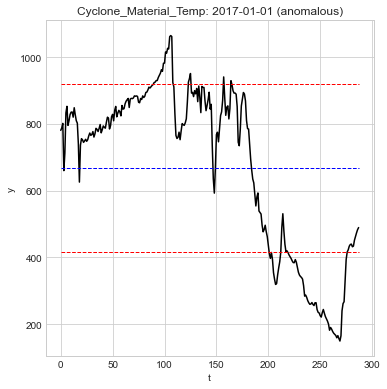

In [29]:
## Randomly pick an anomalous sample and plot
j_2_a = np.random.choice(np.where(probability_2 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_2.iloc[int(j_2_a)], 't', 'y', feature_2 + ': ' + df_2.index[0].strftime('%Y-%m-%d') + ' (anomalous)', ax)

# For the third feature Cyclone_Outlet_Gas_draft:

In [30]:
feature_3 = df.columns[2] # "Cyclone_Inlet_Gas_Temp"
df_3 = df.groupby("date").apply(lambda x: x[feature_3].values if len(x[feature_3].values) == 288 else np.nan)
df_3 = df_3.dropna()
fftmag_3 =  np.abs(np.array([fft(x) for x in df_3.values]))
df_dist_3 = pd.DataFrame(squareform(pdist(np.abs(fftmag_3), 'euclidean')))
df_dist_3.index = df_3.index.copy()
df_dist_3.columns = df_3.index.copy()
df_dist_3.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,2002.805484,1734.344650,3840.106691,2682.251778,4947.371213,6635.458242,9314.067182,6138.702196,5723.538007,...,18823.772245,19307.530394,23241.088640,17700.366540,16957.898376,15602.139762,17910.748971,15602.451038,15004.003640,14775.605911
2017-01-02,2002.805484,0.000000,797.109913,3310.084142,1074.898569,3276.850193,4974.170787,7628.852997,4355.137333,4020.121489,...,16996.865082,17478.939644,22981.105062,15887.058741,15121.666107,13816.722292,16143.872570,13793.624415,13211.576030,12997.759713
2017-01-03,1734.344650,797.109913,0.000000,3230.213638,1298.974993,3517.073156,5215.128825,7899.480032,4658.369496,4316.257962,...,17340.239887,17823.090808,22886.982511,16227.208891,15449.337467,14129.485684,16458.340151,14118.310350,13551.025452,13307.841348
2017-01-04,3840.106691,3310.084142,3230.213638,0.000000,3264.968017,3582.270791,4651.019059,6790.717192,4611.692364,4266.704723,...,16720.460366,17326.613517,20413.379387,15702.572610,14935.030864,13355.717741,15665.009752,13486.374018,12801.374087,12600.018132
2017-01-05,2682.251778,1074.898569,1298.974993,3264.968017,0.000000,2698.286139,4469.590305,7055.220474,3800.527931,3540.430081,...,16396.624598,16883.866982,22784.112391,15297.630388,14506.321867,13206.232242,15566.476979,13189.113773,12608.609545,12419.268994


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


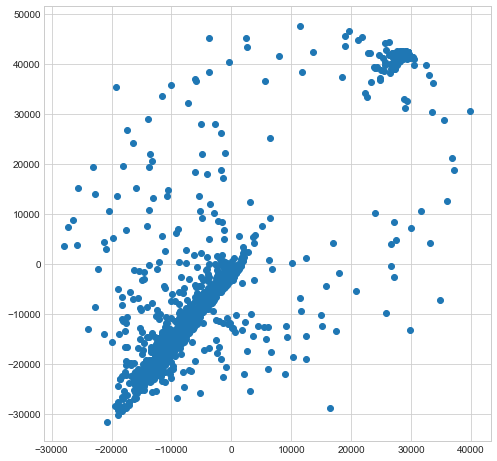

In [31]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_3 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_3 = model_3.fit_transform(df_dist_3)
plt.figure(figsize=(8, 8))
plt.scatter(mds_out_3[:, 0], mds_out_3[:, 1])


In [32]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_3.shape[0])
k = int(np.floor(k))
radius_3 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_3).kneighbors(mds_out_3)[0][:, -1]
f_3 = k / (np.pi * radius_3**2)
f_max_3 = np.amax(f_3)
probability_3 = 1 - (f_3 / f_max_3)


In [33]:
## Anomalous samples
np.where(probability_3 > 0.999)[0]


array([  22,   24,   25,   27,   31,   38,   60,   65,   70,   79,   83,
         84,   87,   88,   92,   93,   94,   96,  100,  107,  108,  128,
        134,  135,  138,  139,  149,  150,  151,  153,  154,  156,  158,
        159,  162,  164,  166,  172,  174,  175,  176,  200,  208,  211,
        216,  220,  231,  236,  251,  254,  255,  256,  259,  261,  291,
        292,  295,  299,  300,  303,  304,  307,  319,  324,  325,  329,
        330,  331,  332,  341,  342,  343,  345,  346,  347,  358,  360,
        361,  362,  364,  371,  379,  393,  394,  395,  396,  400,  405,
        409,  411,  413,  414,  416,  418,  420,  422,  429,  430,  435,
        442,  443,  448,  454,  457,  461,  467,  469,  472,  481,  482,
        483,  484,  485,  487,  490,  491,  492,  493,  499,  502,  504,
        505,  506,  507,  508,  509,  510,  512,  513,  514,  515,  516,
        518,  519,  521,  524,  525,  526,  528,  529,  530,  531,  532,
        533,  535,  538,  539,  541,  542,  543,  5

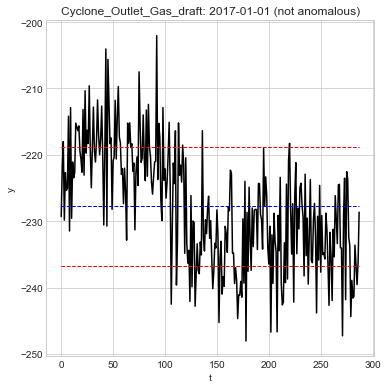

In [42]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_3_na = np.random.choice(np.where(probability_3 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_3.iloc[int(j_3_na)], 't', 'y', feature_3 + ': ' + df_3.index[0].strftime('%Y-%m-%d')+ ' (not anomalous)', ax)

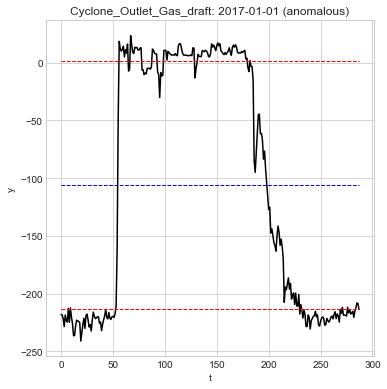

In [44]:
## Randomly pick an anomalous sample and plot
j_3_a = np.random.choice(np.where(probability_3 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_3.iloc[int(j_3_a)], 't', 'y', feature_3 + ': ' + df_3.index[0].strftime('%Y-%m-%d') + ' (anomalous)', ax)

# For the fourth feature Cyclone_cone_draft:

In [45]:
feature_4 = df.columns[3] # "Cyclone_Inlet_Gas_Temp"
df_4 = df.groupby("date").apply(lambda x: x[feature_4].values if len(x[feature_4].values) == 288 else np.nan)
df_4 = df_4.dropna()
fftmag_4 =  np.abs(np.array([fft(x) for x in df_4.values]))
df_dist_4 = pd.DataFrame(squareform(pdist(np.abs(fftmag_4), 'euclidean')))
df_dist_4.index = df_4.index.copy()
df_dist_4.columns = df_4.index.copy()
df_dist_4.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,6358.087619,2012.618161,3430.706326,2658.043834,3836.396169,3719.786040,12641.929260,8406.356515,7362.607382,...,19631.472202,11814.938622,17210.892320,20359.090316,11359.292311,13199.401591,14295.246561,14304.474284,12381.233968,11977.944533
2017-01-02,6358.087619,0.000000,6234.879981,8185.854234,7703.184010,6445.306747,5193.227274,7872.924857,6454.455553,5369.383570,...,15817.908698,7984.019605,14178.312173,16542.667804,7494.456041,9953.496727,10404.290757,11207.322791,7656.280379,8376.577927
2017-01-03,2012.618161,6234.879981,0.000000,4295.900046,3420.211343,4689.063851,4299.063816,12657.819736,8827.331902,7593.631701,...,19923.832758,12121.344417,16620.707037,20652.963884,11531.381801,13628.577001,14563.369487,14700.126639,12518.249656,12234.074936
2017-01-04,3430.706326,8185.854234,4295.900046,0.000000,2522.711366,3573.278689,4721.081850,14090.325006,9248.150584,8874.094372,...,20340.439958,12786.475528,19475.070365,21060.822216,12546.136160,13760.734195,15129.339550,14837.730608,13708.769088,13058.244088
2017-01-05,2658.043834,7703.184010,3420.211343,2522.711366,0.000000,3369.358861,4218.653330,13649.817354,8737.003993,8151.079130,...,20081.644072,12615.205834,19177.625125,20748.150325,12158.864201,13605.121260,14900.819073,14557.124623,13372.138243,12558.218947


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


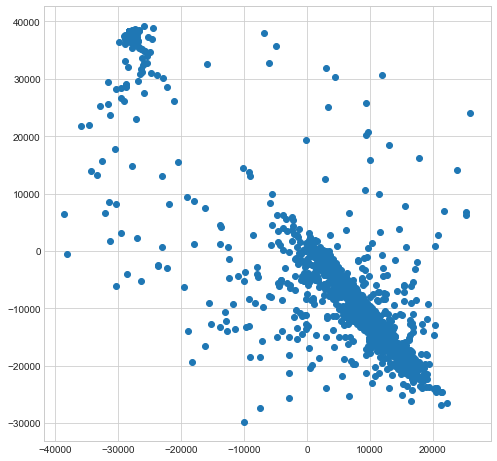

In [46]:
## Fit a 2D MDS model using the distance matrix computed above
d = 2
model_4 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_4 = model_4.fit_transform(df_dist_4)
plt.figure(figsize=(8, 8))
plt.scatter(mds_out_4[:, 0], mds_out_4[:, 1])


In [47]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_4.shape[0])
k = int(np.floor(k))
radius_4 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_4).kneighbors(mds_out_4)[0][:, -1]
f_4 = k / (np.pi * radius_4**2)
f_max_4 = np.amax(f_4)
probability_4 = 1 - (f_4 / f_max_4)


In [48]:
## Anomalous samples
np.where(probability_4 > 0.999)[0]


array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,   11,
         14,   15,   16,   17,   18,   19,   20,   21,   22,   24,   25,
         26,   27,   28,   29,   31,   32,   34,   36,   37,   38,   50,
         53,   54,   55,   57,   58,   59,   60,   61,   62,   63,   64,
         65,   66,   68,   70,   72,   73,   75,   76,   78,   79,   80,
         81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,
         92,   93,   94,   95,   96,   97,  100,  101,  102,  104,  105,
        106,  107,  108,  109,  113,  115,  116,  118,  120,  122,  123,
        124,  125,  126,  127,  128,  129,  130,  131,  133,  134,  135,
        136,  137,  138,  139,  149,  150,  151,  153,  154,  156,  158,
        159,  162,  164,  166,  172,  174,  175,  176,  178,  180,  185,
        187,  189,  190,  200,  208,  209,  211,  216,  220,  231,  232,
        240,  251,  254,  255,  256,  259,  261,  262,  290,  291,  292,
        295,  296,  297,  298,  299,  300,  303,  3

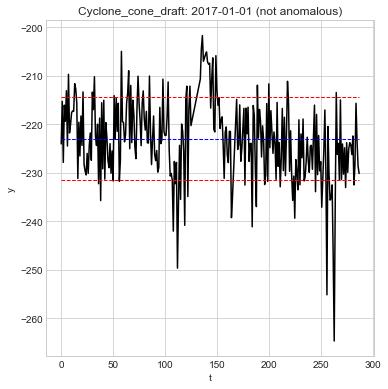

In [49]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_4_na = np.random.choice(np.where(probability_4 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_4.iloc[int(j_4_na)], 't', 'y', feature_4 + ': ' + df_4.index[0].strftime('%Y-%m-%d')+ ' (not anomalous)', ax)

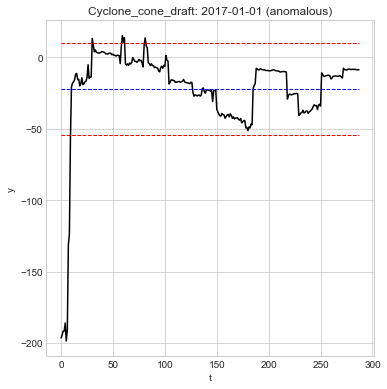

In [61]:
## Randomly pick an anomalous sample and plot
j_4_a = np.random.choice(np.where(probability_4 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_4.iloc[int(j_4_a)], 't', 'y', feature_4 + ': ' + df_4.index[0].strftime('%Y-%m-%d') + ' (anomalous)', ax)

# For the fifth feature Cyclone_Gas_Outlet_Temp:

In [51]:
feature_5 = df.columns[4] # "Cyclone_Inlet_Gas_Temp"
df_5 = df.groupby("date").apply(lambda x: x[feature_5].values if len(x[feature_5].values) == 288 else np.nan)
df_5 = df_5.dropna()
fftmag_5 =  np.abs(np.array([fft(x) for x in df_5.values]))
df_dist_5 = pd.DataFrame(squareform(pdist(np.abs(fftmag_5), 'euclidean')))
df_dist_5.index = df_5.index.copy()
df_dist_5.columns = df_5.index.copy()
df_dist_5.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,2863.740664,4809.038874,4175.285859,4579.381351,3664.459265,3587.187831,5826.541313,6001.166206,5288.110235,...,8523.131632,6747.569771,10469.271195,5489.283266,5731.523714,7546.880749,3888.225591,4659.569088,6494.864447,7953.791038
2017-01-02,2863.740664,0.000000,6500.508495,5698.425639,5436.603623,3249.921968,5326.762539,7341.820873,7057.115762,6218.130912,...,7655.823384,6106.348798,9385.962722,5234.212019,5343.750644,6294.379086,3559.727772,4139.727679,5609.615703,6957.139068
2017-01-03,4809.038874,6500.508495,0.000000,2347.674102,3310.697378,7575.570938,2755.435425,3664.827367,3384.984980,3788.240710,...,12667.412597,10891.280389,12801.645959,9404.996605,9680.533444,11789.147748,7770.497683,8798.959902,10694.535775,12218.693948
2017-01-04,4175.285859,5698.425639,2347.674102,0.000000,3177.440218,6835.080922,2374.815135,3425.215978,3227.030869,3527.922482,...,11942.792943,10240.389769,11810.623410,8849.478880,9098.764725,10983.838221,7171.182135,8149.632285,9991.554440,11481.108418
2017-01-05,4579.381351,5436.603623,3310.697378,3177.440218,0.000000,7233.201440,3675.406387,4651.719545,3148.390703,2803.989342,...,12144.263013,10556.620221,10435.463635,9196.432370,9489.745809,10944.753610,7386.377946,8283.322389,10138.009523,11573.736900


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


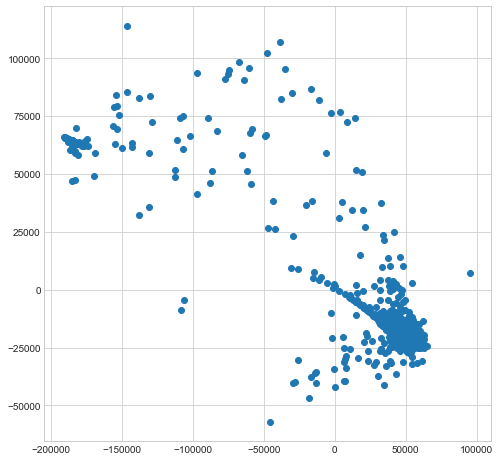

In [52]:
d = 2
model_5 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_5 = model_5.fit_transform(df_dist_5)
plt.figure(figsize=(8, 8))
plt.scatter(mds_out_5[:, 0], mds_out_5[:, 1])

In [53]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_5.shape[0])
k = int(np.floor(k))
radius_5 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_5).kneighbors(mds_out_5)[0][:, -1]
f_5 = k / (np.pi * radius_5**2)
f_max_5 = np.amax(f_5)
probability_5 = 1 - (f_5 / f_max_5)


In [54]:
## Anomalous samples
np.where(probability_5 > 0.999)[0]

array([  22,   60,   79,   80,   81,   82,   83,   94,   95,   96,  138,
        149,  150,  158,  159,  164,  200,  211,  251,  254,  255,  256,
        258,  261,  283,  290,  291,  292,  299,  303,  330,  331,  340,
        341,  379,  395,  396,  405,  409,  410,  411,  413,  420,  430,
        431,  432,  433,  434,  435,  436,  437,  438,  439,  440,  441,
        442,  454,  455,  456,  457,  473,  474,  475,  476,  477,  478,
        479,  480,  481,  482,  483,  484,  487,  488,  489,  490,  491,
        492,  493,  494,  498,  499,  500,  501,  503,  504,  506,  507,
        514,  515,  519,  520,  521,  533,  534,  535,  541,  542,  548,
        549,  552,  553,  554,  557,  558,  559,  565,  574,  604,  608,
        621,  622,  623,  631,  632,  652,  653,  654,  659,  662,  671,
        672,  694,  695,  696,  697,  703,  704,  706,  710,  730,  761,
        762,  763,  764,  765,  766,  767,  768,  769,  770,  795,  796,
        803,  804,  808,  809,  810,  811,  812,  8

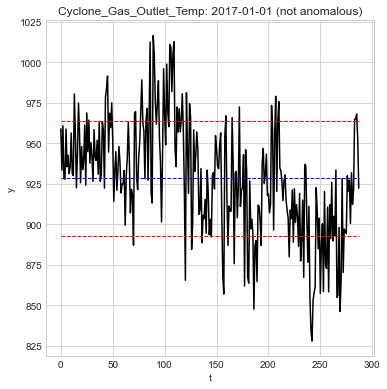

In [57]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_5_na = np.random.choice(np.where(probability_5 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_5.iloc[int(j_5_na)], 't', 'y', feature_5 + ': ' + df_5.index[0].strftime('%Y-%m-%d')+ ' (not anomalous)', ax)

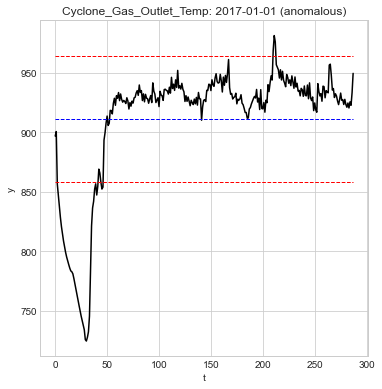

In [71]:
## Randomly pick an anomalous sample and plot
j_5_a = np.random.choice(np.where(probability_5 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_5.iloc[int(j_5_a)], 't', 'y', feature_5 + ': ' + df_5.index[0].strftime('%Y-%m-%d') + ' (anomalous)', ax)

#  For the sixth feature Cyclone_Inlet_Draft:

In [65]:
feature_6 = df.columns[5] # "Cyclone_Inlet_Gas_Temp"
df_6 = df.groupby("date").apply(lambda x: x[feature_6].values if len(x[feature_6].values) == 288 else np.nan)
df_6 = df_6.dropna()
fftmag_6 =  np.abs(np.array([fft(x) for x in df_6.values]))
df_dist_6 = pd.DataFrame(squareform(pdist(np.abs(fftmag_6), 'euclidean')))
df_dist_6.index = df_6.index.copy()
df_dist_6.columns = df_6.index.copy()
df_dist_6.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,1843.594017,1696.652086,3658.970745,3567.350027,5691.925038,6151.613680,7485.804523,4826.073427,4909.546410,...,14459.785184,14677.550551,17944.552603,13079.566114,12355.717427,11023.876420,13255.596360,11186.399415,10881.581300,10716.343021
2017-01-02,1843.594017,0.000000,1120.419058,2910.659823,2054.414914,4183.844014,4663.293039,6019.733305,3371.528038,3475.917068,...,12855.613709,13068.834351,17881.021562,11484.657337,10738.802867,9489.828664,11733.076929,9616.729365,9312.233344,9176.352631
2017-01-03,1696.652086,1120.419058,0.000000,2813.696554,2314.677802,4389.311979,4806.312048,6117.528548,3493.060179,3554.251514,...,13083.055245,13286.716585,17453.917495,11688.959790,10967.560382,9627.270372,11859.327042,9788.408171,9537.307406,9330.117432
2017-01-04,3658.970745,2910.659823,2813.696554,0.000000,2752.738078,3562.085583,3945.647204,4803.978532,2968.600492,3156.456501,...,11987.578567,12281.948913,15810.590041,10736.304633,9979.250705,8457.872631,10735.498918,8724.277091,8329.073445,8226.517313
2017-01-05,3567.350027,2054.414914,2314.677802,2752.738078,0.000000,2569.500321,3116.572037,4440.022885,1865.876666,2118.026200,...,11071.139448,11303.901631,17691.490737,9719.787138,8935.270308,7732.715661,10031.980738,7849.190630,7537.184019,7438.162500


C:\Users\ibner\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


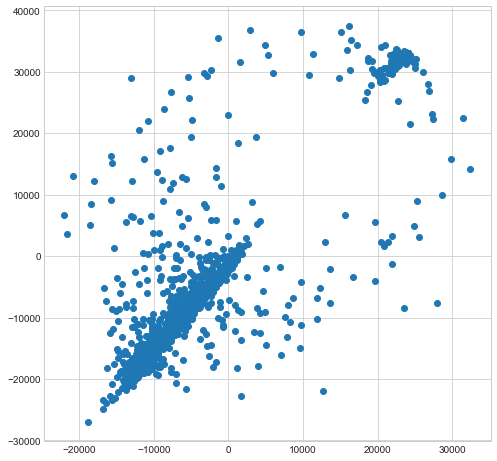

In [66]:
d = 2
model_6 = MDS(n_components = d, dissimilarity = 'precomputed', random_state = 1)
mds_out_6 = model_6.fit_transform(df_dist_6)
plt.figure(figsize=(8, 8))
plt.scatter(mds_out_6[:, 0], mds_out_6[:, 1])

In [67]:
## Compute probability density of a sample being anomalous as
## k / volume of smallest hypersphere containing k NNs of that sample.
## Here k = O(M^(1/d)), where M = no. of samples and d = 2 (the reduced dimensionality)
k = np.sqrt(df_6.shape[0])
k = int(np.floor(k))
radius_6 = NearestNeighbors(n_neighbors = k+1, algorithm = 'ball_tree').fit(mds_out_6).kneighbors(mds_out_6)[0][:, -1]
f_6 = k / (np.pi * radius_6**2)
f_max_6 = np.amax(f_6)
probability_6 = 1 - (f_6 / f_max_6)


In [68]:
## Anomalous samples
np.where(probability_6 > 0.999)[0]

array([  14,   18,   21,   22,   24,   25,   31,   38,   60,   65,   66,
         70,   79,   81,   83,   84,   87,   88,   90,   92,   93,   94,
         96,  100,  107,  108,  118,  128,  134,  135,  136,  137,  138,
        139,  149,  150,  151,  153,  154,  156,  158,  159,  160,  161,
        162,  164,  166,  172,  174,  175,  176,  180,  200,  208,  211,
        216,  220,  231,  251,  254,  255,  256,  259,  261,  262,  291,
        292,  295,  299,  303,  304,  307,  310,  319,  325,  329,  330,
        331,  332,  341,  342,  343,  345,  346,  347,  358,  360,  361,
        362,  364,  371,  372,  379,  381,  393,  394,  395,  396,  400,
        405,  409,  411,  413,  414,  416,  418,  420,  422,  423,  429,
        430,  435,  442,  443,  448,  454,  455,  457,  461,  467,  469,
        470,  472,  481,  482,  483,  484,  485,  487,  490,  491,  492,
        493,  499,  501,  502,  504,  505,  506,  507,  508,  509,  510,
        512,  513,  514,  515,  516,  519,  520,  5

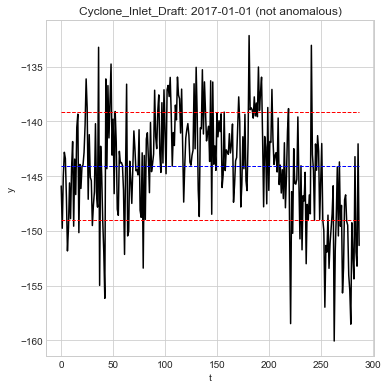

In [70]:
## Randomly pick a non-anomalous sample and plot
prob_cutoff = 0.999
j_6_na = np.random.choice(np.where(probability_6 <= prob_cutoff )[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_6.iloc[int(j_6_na)], 't', 'y', feature_6 + ': ' + df_6.index[0].strftime('%Y-%m-%d')+ ' (not anomalous)', ax)

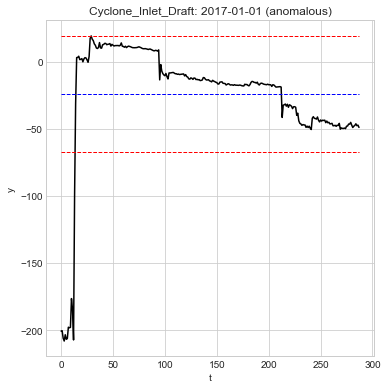

In [72]:
## Randomly pick an anomalous sample and plot
j_6_a = np.random.choice(np.where(probability_6 > prob_cutoff)[0], 1)
fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
plotveccomp(df_6.iloc[int(j_6_a)], 't', 'y', feature_6 + ': ' + df_6.index[0].strftime('%Y-%m-%d') + ' (anomalous)', ax)